In [1]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = "numpy" # delete if get c++ build tools working

In [2]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    scatter(S.x_pre/um, S.x_post/um, S.w*20)
    xlabel('Source neuron position (um)')
    ylabel('Target neuron position (um)');

In [4]:
# trying to recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N = 10                      # number of neurons

# stdp params
wMax = 5 * uamp * cm**-2    # max syn weight
tauPre = tauPost = 5 * ms   # synaptic time constant
dApre =                     # ???
dApost =                    # ???

# model
# TODO: add noise term (Isyn)
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta)) / C : volt (unless refractory)
'''

G = NeuronGroup(N, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

S = Synapses(G, G,
             '''w : 1
                dApre/dt = -Apre / tauPre : 1 (event-driven)
                dApost/dt = -Apost / tauPost : 1 (event-driven)''',
             on_pre='''v += w
                    Apre += dApre
                    w = clip(w + Apost, 0, wMax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, wMax)'''
            )
           
# TODO: initialize mean weight over some distribution?
S.connect(condition='i!=j', p=p)
S.w = '0.2'

M = StateMonitor(G, 'v', record=True)

# initial value
G.v = 5 * mV 

# run
run(60*ms)

# plots
visualise_connectivity(S)


plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\core\network.py", line 901, in before_run
    obj.before_run(run_namespace)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\core\base.py", line 280, in device_override_decorated_function
    return func(*args, **kwds)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\synapses\synapses.py", line 319, in before_run
    CodeRunner.before_run(self, run_namespace)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\groups\group.py", line 1133, in before_run
    codeobj_class=self.codeobj_class
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\codegen\codeobject.py", line 325, in create_runner_codeobj
    run_namespace=run_namespace)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\groups\group.py", line 744, in resolve_all
    run_namespace=run_namespace)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\groups\group.py", line 701, in _resolve
    return self._resolve_external(identifier, run_namespace=run_namespace)
  File "C:\Users\bdoty\.virtualenvs\ocker-stdp-motifs-_EyvY4cK\lib\site-packages\brian2\groups\group.py", line 825, in _resolve_external
    raise KeyError(error_msg)
KeyError: 'The identifier "dApre" could not be resolved.'

Error encountered with object named "synapses_1_pre".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-4-9970db2c0484>", line 45, in <module>
    w = clip(w + Apre, 0, wMax)'''

An error occurred when preparing an object. KeyError: 'The identifier "dApre" could not be resolved.'
(See above for original error message and traceback.)

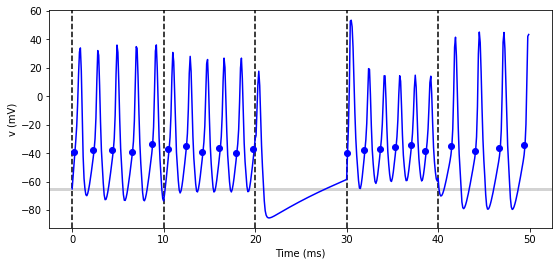

In [16]:
# example from brian2 website
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

WARNING    "C" is an internal variable of group "neurongroup_10", but also exists in the run namespace with the value 0.01 * metre ** -4 * kilogram ** -1 * second ** 4 * amp ** 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


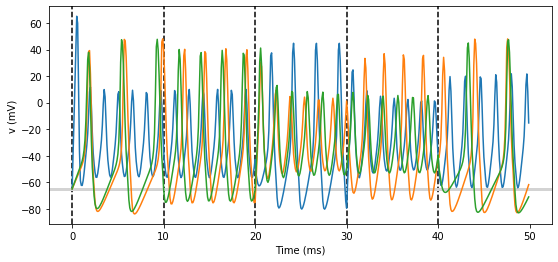

In [43]:
# example from brian2 website
start_scope()
N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');

Starting simulation at t=0. s for a duration of 100. s
4.4734 s (4%) simulated in 10s, estimated 3m 34s remaining.
8.8147 s (8%) simulated in 20s, estimated 3m 27s remaining.
13.2049 s (13%) simulated in 30s, estimated 3m 17s remaining.
17.6737 s (17%) simulated in 40s, estimated 3m 6s remaining.
22.1403 s (22%) simulated in 50s, estimated 2m 56s remaining.
26.5949 s (26%) simulated in 1m 0s, estimated 2m 46s remaining.
30.9149 s (30%) simulated in 1m 10s, estimated 2m 36s remaining.
35.2211 s (35%) simulated in 1m 20s, estimated 2m 27s remaining.
39.4375 s (39%) simulated in 1m 30s, estimated 2m 18s remaining.
43.8008 s (43%) simulated in 1m 40s, estimated 2m 8s remaining.
48.1844 s (48%) simulated in 1m 50s, estimated 1m 58s remaining.
52.579 s (52%) simulated in 2m 0s, estimated 1m 48s remaining.
56.9716 s (56%) simulated in 2m 10s, estimated 1m 38s remaining.
61.3335 s (61%) simulated in 2m 20s, estimated 1m 28s remaining.
65.5129 s (65%) simulated in 2m 30s, estimated 1m 19s remai

<IPython.core.display.Javascript object>


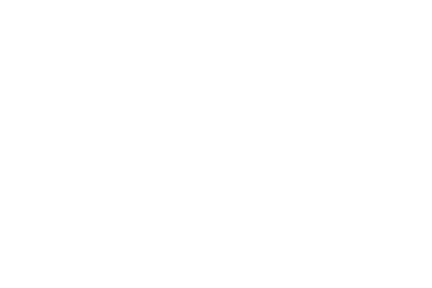

<IPython.core.display.Javascript object>


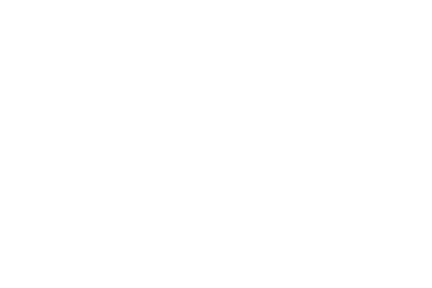

In [45]:
# stdp example from brian2 website

%matplotlib notebook
start_scope()
from brian2 import *
N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''
input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='exact')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)
run(100*second, report='text')
subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()